In [96]:
import pandas
import geopandas
import numpy as np

In [97]:
# Ensure that the GDB exists in the tmp folder (~760MB)
# Note that the 2020 GDB does not include geometries (not sure why)
# 
us = geopandas.read_file(
    "/tmp/EJSCREEN_2019_USPR.gdb.zip", 
    driver="FileGDB"
)

In [98]:
# Select California and a set of high-priority columns
column_list = [
    "ID",
    "geometry", 
    "STATE_NAME",
    "D_RESP_2", 
    "D_OZONE_2", 
    "D_PM25_2"
]

cali = us[us.STATE_NAME == "California"][column_list]
cali = cali.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [99]:
# add tract identifier, just the first 11 characters of the ID string
# dissolve by tract
cali["tract"] = cali["ID"].apply(lambda s: s[:11])
cali = cali.dissolve(by='tract', aggfunc ='mean')

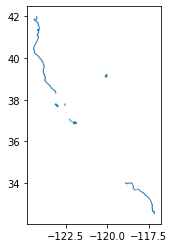

In [100]:
# Read and merge Flood Factor data
flood_factor = pandas.read_csv(
    "../data/fsf_tract_summary.csv",
    usecols=["fips", "avg_risk_score_all"],
    dtype={"fips": np.str}
)

ff_df = cali.merge(
    flood_factor, 
    how="left", 
    left_on="tract", 
    right_on="fips", 
    indicator=True
)

# Note that there are 13 tracts without Flood Factor data
# and then drop the extra columns.  Those tracts seem to not have 
# any data at all, not just flood factor data.  Drop those tracts.
ff_df[ff_df._merge == "left_only"].plot()
cali_expanded = ff_df[ff_df._merge == "both"]
cali_expanded = ff_df.drop(columns=["_merge", "fips"])

# In fact, there are a few tracts without scores.  Let's just 
# drop them, wholesale.
cali_expanded = cali_expanded.dropna()

In [101]:
# Bucket the flood factor data
cali_expanded["flood_bucket"] = pandas.qcut(
    x=cali_expanded.avg_risk_score_all, 
    q=10, 
    labels=False
)

In [102]:
# dissolve the boundaries by tract and then explode the multipolygons into 
# individual polygons again
cali_dissolved = cali_expanded.dissolve(by='flood_bucket', aggfunc='mean')
final = cali_dissolved.explode().reset_index(drop=True)
final.to_file("../data/flood_factor_bucket.geojson", driver="GeoJSON")

In [104]:
final

,D_RESP_2,D_OZONE_2,D_PM25_2,avg_risk_score_all,geometry
0,230.827792,18699.507899,4128.433092,1.005635,"POLYGON ((-117.06241 32.55885, -117.06241 32.5..."
1,230.827792,18699.507899,4128.433092,1.005635,"POLYGON ((-117.11006 32.57655, -117.11004 32.5..."
2,230.827792,18699.507899,4128.433092,1.005635,"POLYGON ((-117.10145 32.55832, -117.10144 32.5..."
3,230.827792,18699.507899,4128.433092,1.005635,"POLYGON ((-117.05404 32.58374, -117.05383 32.5..."
4,230.827792,18699.507899,4128.433092,1.005635,"POLYGON ((-116.97119 32.62531, -116.97118 32.6..."
...,...,...,...,...,...
4315,186.488276,15663.041451,3144.788780,4.189084,"POLYGON ((-122.28446 40.46952, -122.28438 40.4..."
4316,186.488276,15663.041451,3144.788780,4.189084,"POLYGON ((-122.35783 40.53873, -122.35438 40.5..."
4317,186.488276,15663.041451,3144.788780,4.189084,"POLYGON ((-124.24439 40.76952, -124.24099 40.7..."
4318,186.488276,15663.041451,3144.788780,4.189084,"POLYGON ((-124.19323 41.73136, -124.19330 41.7..."


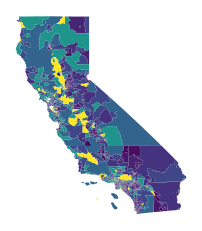

In [103]:
ax = final.plot(
    column = "avg_risk_score_all",
    linewidth = -1
)

ax.axis('off')
plt.savefig('zoom.png', dpi=300)